<a href="https://colab.research.google.com/github/AlexTsikhun/t-spark-ml-test/blob/main/t_spark_yolov5_coco_subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning YOLOv5 in COCO subset and saving quantized model

### Prepare COCO dataset of a specific (human and car) subset of classes
Install COCO dataset (annotations and images)

In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q /content/annotations_trainval2014.zip

--2023-08-30 15:29:04--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.104.52, 54.231.167.97, 54.231.235.41, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.104.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  13.1MB/s    in 21s     

2023-08-30 15:29:25 (11.7 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]



In [3]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q /content/train2014.zip

--2023-08-30 15:29:35--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.121.97, 3.5.29.174, 3.5.25.60, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.121.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  12.9MB/s    in 17m 28s 

2023-08-30 15:47:03 (12.3 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [4]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip -q /content/val2014.zip

--2023-08-30 15:49:14--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.201, 3.5.25.187, 52.217.92.252, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  13.2MB/s    in 8m 18s  

2023-08-30 15:57:33 (12.7 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [5]:
# for debugging
! pip install -q icecream

In [7]:
import json
import os
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import shutil

In [6]:
# shutil.rmtree('/content/filtered_data')

Delete redundant .zip for less memory usage

In [8]:
os.remove('/content/train2014.zip')
os.remove('/content/val2014.zip')
os.remove('/content/annotations_trainval2014.zip')

In [9]:
classes_to_detect = ['person', 'car']
category_ids = [1, 3]

In [10]:
# make proper YOLO folder structure
annotations_path = '/content/annotations'
train_images_path = '/content/train2014'
val_images_path = '/content/val2014'
output_path = '/content/filtered_data'

train_images_output_path = os.path.join(output_path, 'train', 'images')
train_labels_output_path = os.path.join(output_path, 'train', 'labels')

val_images_output_path = os.path.join(output_path, 'val', 'images')
val_labels_output_path = os.path.join(output_path, 'val', 'labels')

os.makedirs(train_images_output_path, exist_ok=True)
os.makedirs(train_labels_output_path, exist_ok=True)
os.makedirs(val_images_output_path, exist_ok=True)
os.makedirs(val_labels_output_path, exist_ok=True)

Loading annotations

In [11]:
with open(os.path.join(annotations_path, 'instances_train2014.json'), 'r') as f:
    train_coco_data = json.load(f)

train_annotations = train_coco_data['annotations']
train_images = train_coco_data['images']

In [12]:
with open(os.path.join(annotations_path, 'instances_val2014.json'), 'r') as f:
    val_coco_data = json.load(f)

val_annotations = val_coco_data['annotations']
val_images = val_coco_data['images']

In [13]:
annotations_index = {}
for ann in train_annotations + val_annotations:
    image_id = ann['image_id']
    category_id = ann['category_id']
    if image_id not in annotations_index:
        annotations_index[image_id] = []
    if category_id in category_ids:
        annotations_index[image_id].append(ann)

In [14]:
def process_image(image_info, images_path, images_output_path, labels_output_path):
    image_id = image_info['id']
    image_filename = image_info['file_name']

    image_annotations = annotations_index.get(image_id, [])

    if image_annotations:
        annotations_data = []
        for ann in image_annotations:
            category_id = ann['category_id']
            if category_id in category_ids:
                bbox = ann['bbox']
                x_center = (bbox[0] + bbox[2] / 2) / image_info['width']
                y_center = (bbox[1] + bbox[3] / 2) / image_info['height']
                width = bbox[2] / image_info['width']
                height = bbox[3] / image_info['height']
                annotations_data.append(f"{category_ids.index(category_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        if annotations_data:
            txt_filename = os.path.splitext(image_filename)[0] + '.txt'
            txt_path = os.path.join(labels_output_path, txt_filename)
            with open(txt_path, 'w') as txt_file:
                txt_file.writelines(annotations_data)

            output_image_path = os.path.join(images_output_path, image_filename)
            os.symlink(os.path.join(images_path, image_filename), output_image_path)


In [15]:
def process_images(images_info, images_path, images_output_path, labels_output_path):
    for image_info in images_info:
        process_image(image_info, images_path, images_output_path, labels_output_path)

process_images(train_images, train_images_path, train_images_output_path, train_labels_output_path)
process_images(val_images, val_images_path, val_images_output_path, val_labels_output_path)

In [16]:
# count files
if os.path.exists('/content/filtered_data/val/labels'):
    files = os.listdir('/content/filtered_data/val/labels')
    num_files = len(files)
    print(f"Number of files in the folder: {num_files}")
else:
    print("Folder not found")

Number of files in the folder: 22998


In [17]:
# can delete annotations folder, train2014 and val2014

Visualize some examples

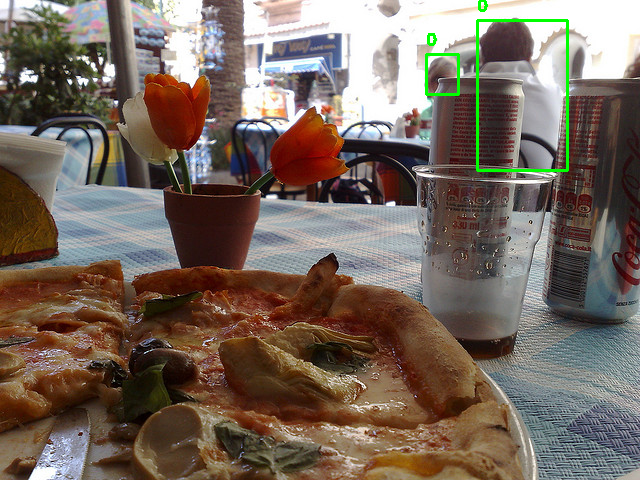

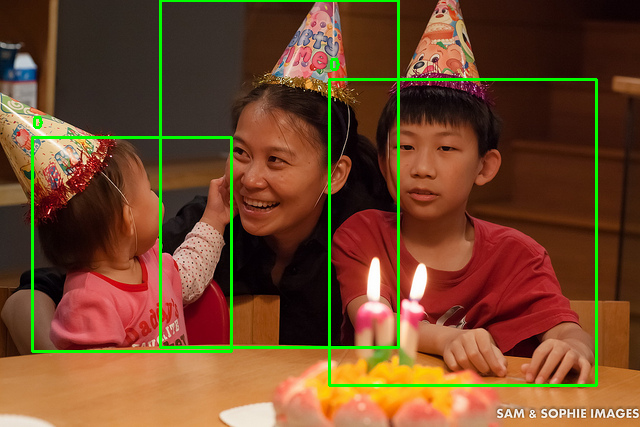

In [18]:
import cv2
import os
from google.colab.patches import cv2_imshow

image_folder = "/content/filtered_data/train/images"
txt_folder = "/content/filtered_data/train/labels"

displayed_images = 0
max_display = 2

for image_filename in os.listdir(image_folder):
    if displayed_images >= max_display:
        break

    if image_filename.endswith(".jpg"):
        image_path = os.path.join(image_folder, image_filename)
        txt_filename = os.path.splitext(image_filename)[0] + ".txt"
        txt_path = os.path.join(txt_folder, txt_filename)
        image = cv2.imread(image_path)

        with open(txt_path, "r") as txt_file:
            lines = txt_file.readlines()

        bounding_boxes = []
        for line in lines:
            class_label, x_center, y_center, width, height = map(float, line.strip().split())
            bounding_boxes.append((x_center, y_center, width, height, class_label))

        for box in bounding_boxes:
            x_center, y_center, width, height, class_label = box
            x1 = int((x_center - width / 2) * image.shape[1])
            y1 = int((y_center - height / 2) * image.shape[0])
            x2 = int((x_center + width / 2) * image.shape[1])
            y2 = int((y_center + height / 2) * image.shape[0])

            color = (0, 255, 0)
            thickness = 2

            # draw
            cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
            cv2.putText(image, str(int(class_label)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        cv2_imshow(image)
        cv2.waitKey(0)
        displayed_images += 1

cv2.destroyAllWindows()


Save to Google Drive zipped archive of filtered data

In [19]:
# import shutil
# # zipping
# source_folder_path = '/content/data'
# zip_filename = '/content/filtered_data'

# shutil.make_archive(zip_filename, 'zip', source_folder_path)

'/content/filtered_data.zip'

In [20]:
# from google.colab import files

# file_path = '/content/filtered_data.zip'
# files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Fine tuning YOLOv5

In [21]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 46.4/78.2 GB disk)


In [ ]:
## custom.yaml
# train: /content/filtered_data/train
# val: /content/filtered_data/val

# nc: 2
# names: ['person', 'car']

In [22]:
!python train.py --img 640 --batch 1 --epochs 1 --data custom.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, deg

In [25]:
# make tflite
!python export.py --weights /content/yolov5/runs/train/exp/weights/best.pt --include tflite

export: data=data/coco128.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/exp/weights/best.pt with output shape (1, 25200, 7) (13.7 MB)

TensorFlow SavedModel: starting export with tensorflow 2.12.0...

                 from  n    params  module                                  arguments                     
2023-08-30 17:50:19.766617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is de

In [26]:
# checking tflite model
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best-fp16.tflite

detect: weights=['/content/yolov5/runs/train/exp/weights/best-fp16.tflite'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Loading /content/yolov5/runs/train/exp/weights/best-fp16.tflite for TensorFlow Lite inference...
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
image 1/2 /content/yolov5/data/images/bus.jpg: 640x640 4 persons, 666.4ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 640x640 2 persons, 442.1ms
Speed: 49.9ms pre-process, 554.2ms inference, 154.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs

In [32]:
import tensorflow as tf

saved_model_path = '/content/yolov5/runs/train/exp/weights/best_saved_model'
model = tf.saved_model.load(saved_model_path)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# save in yolov5 folder
quantized_model_path = 'quantized_model.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(quantized_tflite_model)


In [35]:
# checking quantized_model
!python detect.py --weights /content/yolov5/quantized_model.tflite

detect: weights=['/content/yolov5/quantized_model.tflite'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Loading /content/yolov5/quantized_model.tflite for TensorFlow Lite inference...
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
image 1/2 /content/yolov5/data/images/bus.jpg: 640x640 4 persons, 724.3ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 640x640 2 persons, 700.8ms
Speed: 18.8ms pre-process, 712.5ms inference, 58.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


You can check model results here: '/content/yolov5/runs/train/exp/weights'

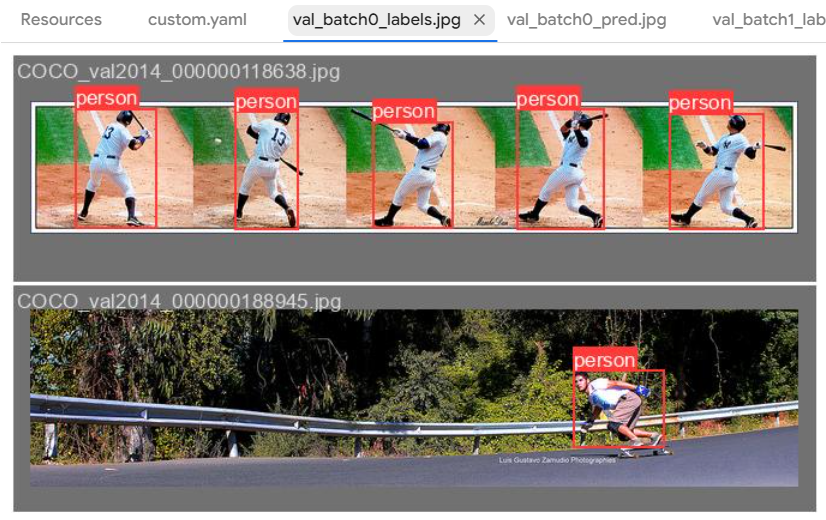

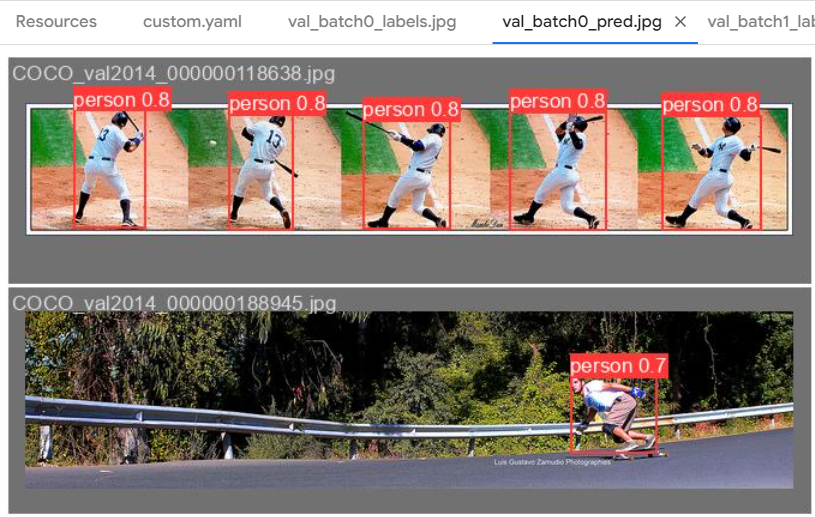

Plan to improve model accuracy:

Data augmentation: displacement, rotation, scaling, blurring, and brightness changes, will help the model learn to recognize objects in different contexts.

Class balance: My dataset highly imbalanced

Tune hyperparameters and settings: this is took a lot of time because YOLO computation is very slow (1.5h for 1 epoch). But the problem is solved by using smaller subset of data for parametr tuning

For all classes combined:

- Precision (P): 0.744
- Recall (R): 0.581
- Mean Average Precision (mAP) at IoU threshold 0.50: 0.659
- Mean Average Precision (mAP) at IoU thresholds 0.50 to 0.95: 0.382

The model is working, the results will be better if you train it longer (1 epoch is not enough for reach good output)